In [324]:
import gdown
import pandas as pd
import random
import json

In [263]:
# gdown.download('https://drive.google.com/file/d/17NBXx6l_6znStM52RJOKKKlxnHigavzq/view', fuzzy=True)

In [264]:
# tar -xvzf hackathon_objects.tar.gz

In [2]:
goods_data = pd.read_parquet('../datasets/train_data.parquet')

goods_pairs = pd.read_parquet('../datasets/train_pairs_w_target.parquet')

In [3]:
goods_pairs.head()

,target,variantid1,variantid2
0,0.0,51197862,51198054
1,1.0,53062686,536165289
2,1.0,53602615,587809782
3,1.0,53888651,89598677
4,0.0,56930698,551526166


In [4]:
goods_data.head()

,variantid,characteristic_attributes_mapping,name,categories,color_parsed,pic_embeddings_resnet_v1,main_pic_embeddings_resnet_v1,name_bert_64
0,51195767,"{""85"":[""Партнер-Электро""],""8229"":[""Удлинитель ...","Удлинитель Партнер-Электро ПВС 2х0,75 ГОСТ,6A,...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[оранжевый],None,"[[0.04603629, 0.18839523, -0.09973055, -0.6636...","[-0.47045058, 0.67237014, 0.48984158, -0.54485..."
1,51196903,"{""85"":[""TDM Electric""],""8229"":[""Удлинитель быт...",Колодка TDM Electric пятиместная без заземлени...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],"[[0.42044494, -0.33794826, -0.037247024, 0.165...","[[0.16211876, -0.4455993, 0.6131705, 0.5954206...","[-0.48503304, 0.6264443, 0.6406273, -0.4696772..."
2,52061880,"{""85"":[""MINAMOTO""],""8229"":[""Батарейка""],""5111""...",Батарейка литиевая CR 1/3N 3V (CR11108) Minamo...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Батарей...",None,"[[0.66729844, -0.023996592, 0.42721167, 0.0205...","[[-0.8638098, -0.1625915, -0.034600798, 0.1337...","[-0.15832633, 0.44736174, 0.31883216, -0.55559..."
3,52067481,"{""85"":[""Duracell""],""8229"":[""Батарейка""],""5111""...","Батарейки DURACELL Ultra Power AA (LR6), 4 шт","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Батарей...",None,"[[0.3516068, 0.6306597, 0.80962396, -0.0104141...","[[-0.26286322, 0.22858405, 0.4346232, 0.023486...","[-0.42703134, 0.16898727, 0.53922343, -0.53523..."
4,52610752,"{""85"":[""HP""],""8229"":[""Картридж""],""5708"":[""для ...",Картридж лазерный HP 12A Q2612A черный для LJ ...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...","[черный, чер]","[[-0.009966308, 0.70965785, 0.10790472, -0.411...","[[0.09032486, 0.74205226, 0.30355096, -0.04755...","[-0.4892143, 0.47568643, 0.6505941, -0.4106509..."


In [5]:
goods_data['main_pic_embeddings_resnet_v1'][0][0][0]

0.04603629

In [39]:
def symm_pairs(df):
    # todo: complete cliques of goods
    
    df2 = df.copy()
    cols = ["variantid1", "variantid2"]
    for c in cols:
        if c not in df2.columns:
            raise UserWarning
    df2 = df2.rename(columns={cols[0]: cols[1], cols[1]: cols[0]})
    return pd.concat([df, df2]).drop_duplicates()

In [257]:
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader


class ContrastiveDataset(Dataset):
    def __init__(self, original_dataset, pairs_dataset, embedding_columns):
        self.original_dataset = original_dataset.set_index('variantid')
        self.pairs_dataset = pairs_dataset
        self.embedding_columns = embedding_columns
        self.dataset = None
        self.prepare_dataset()
        

    def prepare_dataset(self,):
        neg_pairs =  self.pairs_dataset[ self.pairs_dataset.target ==0.].groupby('variantid1').variantid2.apply(lambda x: list(x)).to_frame()
        pos_pairs =  self.pairs_dataset[ self.pairs_dataset.target ==1.].groupby('variantid1').variantid2.apply(lambda x: list(x)).to_frame()
        self.dataset = pos_pairs.merge(neg_pairs, how = 'outer', left_index = True, right_index = True, indicator = True, suffixes = ['_pos', '_neg'])
        sol = pd.Series(np.where(self.dataset.variantid2_pos.notnull(), self.dataset.variantid2_pos, pd.Series(self.dataset.index).apply(lambda x: [x])))
        self.dataset['variantid2_pos'] = sol.set_axis(self.dataset.index)
        ld = pd.Series(self.dataset.index).sample(frac = 1).apply(lambda x: [x])
        sol = pd.Series(np.where(self.dataset.variantid2_neg.notnull(), self.dataset.variantid2_neg, ld))
        self.dataset['variantid2_neg'] = sol.set_axis(self.dataset.index)
        self.dataset = self.dataset.reset_index()

    def __getitem__(self, index):
        original_idx = self.dataset.loc[index].variantid1
        positive_idx = self.dataset.loc[index].variantid2_pos
        negative_idx = self.dataset.loc[index].variantid2_neg
        if len(positive_idx)>1:
            val = np.random.choice(len(positive_idx), 1)[0]
            positive_idx = positive_idx[val]
        else:
            positive_idx = positive_idx[0]
        if len(negative_idx)>1:
            val = np.random.choice(len(negative_idx), 1)[0]
            negative_idx = negative_idx[val]
        else:
            negative_idx = negative_idx[0]
        original_data = torch.cat([torch.tensor(self.original_dataset.loc[original_idx]['main_pic_embeddings_resnet_v1'][0]), torch.tensor(self.original_dataset.loc[original_idx]['name_bert_64'])], axis = 0)
        positive_pair = torch.cat([torch.tensor(self.original_dataset.loc[positive_idx]['main_pic_embeddings_resnet_v1'][0]), torch.tensor(self.original_dataset.loc[positive_idx]['name_bert_64'])], axis =0)
        negative_pair = torch.cat([torch.tensor(self.original_dataset.loc[negative_idx]['main_pic_embeddings_resnet_v1'][0]), torch.tensor(self.original_dataset.loc[negative_idx]['name_bert_64'])], axis = 0)
        return original_data, positive_pair, negative_pair, original_idx

    def __len__(self):
        return len(self.dataset)-1

    # def get_embeddings(self, index):
    #     embeddings = []
    #     for column in self.embedding_columns:
    #         embedding = self.original_dataset[column].iloc[index]
    #         if embedding.shape[0] == 1:
    #             embedding = embedding[0]
    #         embeddings.append(embedding)
    #     return torch.tensor(np.concatenate(embeddings))

    # def find_positive_pair(self, original_id):
    #     positive_pairs = self.pairs_dataset[self.pairs_dataset["target"] == 1]
    #     matching_pairs = positive_pairs[(positive_pairs["variantid1"] == original_id)]

    #     if len(matching_pairs) > 0:
    #         # Randomly choose a positive pair if multiple pairs are found
    #         chosen_pair = matching_pairs.sample(1)

    #         # Get the ID of the other data point in the pair
    #         pair_id = chosen_pair["variantid2"].values[0]

    #         # Retrieve the corresponding data from the original dataset
    #         positive_row = self.get_embeddings(
    #             self.original_dataset[
    #                 self.original_dataset["variantid"] == pair_id
    #             ].index[0]
    #         )

    #         return positive_row

    #     # Return original data if positive pair is not found
    #     original_row = self.get_embeddings(
    #         self.original_dataset[
    #             self.original_dataset["variantid"] == original_id
    #         ].index[0]
    #     )
    #     return original_row

    # def find_negative_pair(self, original_id):
    #     negative_pairs = self.pairs_dataset[self.pairs_dataset["target"] == 0]
    #     matching_pairs = negative_pairs[(negative_pairs["variantid1"] == original_id)]

    #     if len(matching_pairs) > 0:
    #         # Randomly choose a positive pair if multiple pairs are found
    #         chosen_pair = matching_pairs.sample(1)

    #         # Get the ID of the other data point in the pair
    #         pair_id = chosen_pair["variantid2"].values[0]

    #         # Retrieve the corresponding data from the original dataset
    #         negative_row = self.get_embeddings(
    #             self.original_dataset[
    #                 self.original_dataset["variantid"] == pair_id
    #             ].index[0]
    #         )

    #         return negative_row

    #     # Return random data if positive pair is not found
    #     random_row = self.get_embeddings(random.choice(self.original_dataset.index))
    #     return random_row




# Actual data

In [258]:
symm_goods_pairs = symm_pairs(goods_pairs)

In [41]:
pos_pairs = symm_goods_pairs[symm_goods_pairs.target ==1].groupby('variantid1').variantid2.apply(lambda x: list(x)).to_frame()

In [47]:
#checking if lists contain duplicates
pos_pairs.variantid2.apply(lambda x: len(x) !=len(set(x))).value_counts()

False    216911
Name: variantid2, dtype: int64

In [43]:
# добавить все симметричные positive pairs
pos_pairs.variantid2.str.len().value_counts()

1     189650
2      18977
3       3806
4       1403
5        734
6        561
7        380
8        287
9        247
10       190
11       166
12       129
13       115
14        72
15        55
16        40
17        24
18        22
20        15
19        14
21         6
22         5
25         3
26         3
23         2
27         2
24         2
28         1
Name: variantid2, dtype: int64

In [259]:
embedding_columns = ['main_pic_embeddings_resnet_v1', 'name_bert_64']

contrastive_dataset = ContrastiveDataset(goods_data, symm_goods_pairs, embedding_columns)

In [260]:
contrastive_dataloader = DataLoader(contrastive_dataset, batch_size=128, shuffle=False, drop_last= True)
next(iter(contrastive_dataloader))[0].shape

torch.Size([128, 192])

In [202]:
yt[0].shape, yt[1].shape, yt[2].shape

(torch.Size([128, 192]), torch.Size([128, 192]), torch.Size([128, 192]))

# Basic train example

In [219]:
contrastive_dataset.dataset.shape

(456741, 4)

In [251]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

In [252]:
#!g1.1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [253]:
#!g1.1
class ContrastiveModel(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_size):
        super(ContrastiveModel, self).__init__()
        
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, embedding_size)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def triplet_loss(anchor, positive, negative, margin=1.0):
    distance_positive = torch.norm(anchor - positive, dim=1)
    distance_negative = torch.norm(anchor - negative, dim=1)
    loss = torch.clamp(distance_positive - distance_negative + margin, min=0.0).mean()
    return loss

# Example parameters
input_size = 192
hidden_size = 64
embedding_size = 32
learning_rate = 0.001
num_epochs = 10

# Create an instance of the model
model = ContrastiveModel(input_size, hidden_size, embedding_size).to(device)

# Define the optimizer and the loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train loop
for epoch in tqdm(range(num_epochs)):
    total_loss = 0.0
    
    for original_data, positive_pair, negative_pair, _ in tqdm(contrastive_dataloader):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        anchor = model(original_data.to(device))
        positive = model(positive_pair.to(device))
        negative = model(negative_pair.to(device))
        
        # Compute the triplet loss
        loss = triplet_loss(anchor, positive, negative)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
   #     print(loss.item())
        total_loss += loss.item()
    
    average_loss = total_loss / len(contrastive_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}")


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3568 [00:00<?, ?it/s]

Epoch [1/10], Average Loss: 0.4593


  0%|          | 0/3568 [00:00<?, ?it/s]

Epoch [2/10], Average Loss: 0.3977


  0%|          | 0/3568 [00:00<?, ?it/s]

Epoch [3/10], Average Loss: 0.3694


  0%|          | 0/3568 [00:00<?, ?it/s]

Epoch [4/10], Average Loss: 0.3379


  0%|          | 0/3568 [00:00<?, ?it/s]

Epoch [5/10], Average Loss: 0.3036


  0%|          | 0/3568 [00:00<?, ?it/s]

Epoch [6/10], Average Loss: 0.2667


  0%|          | 0/3568 [00:00<?, ?it/s]

Epoch [7/10], Average Loss: 0.2367


  0%|          | 0/3568 [00:00<?, ?it/s]

Epoch [8/10], Average Loss: 0.2114


  0%|          | 0/3568 [00:00<?, ?it/s]

Epoch [9/10], Average Loss: 0.1953


  0%|          | 0/3568 [00:00<?, ?it/s]

Epoch [10/10], Average Loss: 0.1820


In [255]:
torch.save(model.state_dict(), 'contrastive_ozon.pt')

In [273]:
def predict(model, dataloader):
    y_idxs = []
    y_embed = []
    for orig, _, _, idx in tqdm(dataloader):
        embed = model(orig.to(device))
        y_idxs.extend([i.detach().cpu().item() for i in idx])
        y_embed.extend([[j.item() for j in i.detach().cpu()] for i in embed])
    return y_idxs, y_embed

y_idxs, y_embed = predict(model, contrastive_dataloader)

        


  0%|          | 0/3568 [00:00<?, ?it/s]

In [275]:
embed = pd.DataFrame({'variant': y_idxs, 'embed': y_embed})

In [281]:
classif = goods_pairs.merge(embed, left_on = 'variantid1', right_on = 'variant', how = 'left', suffixes = ['', '_1'])

In [283]:
classif = classif.merge(embed, left_on = 'variantid2', right_on='variant', how = 'left', suffixes = ['', '_2'])

In [285]:
classif.drop(['variant', 'variant_2'],axis = 1, inplace = True)

In [286]:
classif

,target,variantid1,variantid2,embed,embed_2
0,0.0,51197862,51198054,"[1.4180996417999268, -1.3223673105239868, 1.41...","[0.04952368885278702, -2.240968704223633, 0.43..."
1,1.0,53062686,536165289,"[1.3268283605575562, -3.441253900527954, 2.318...","[0.8855724334716797, -2.7517037391662598, 1.94..."
2,1.0,53602615,587809782,"[1.046702265739441, -3.2472989559173584, 1.840...","[0.6976622343063354, -2.9333677291870117, 2.31..."
3,1.0,53888651,89598677,"[-1.1161519289016724, 1.4208519458770752, 2.15...","[0.019846655428409576, 0.38493552803993225, 1...."
4,0.0,56930698,551526166,"[-2.0551748275756836, -0.1769544780254364, 2.5...","[-1.9071264266967773, -0.020127616822719574, 3..."
...,...,...,...,...,...
306535,0.0,817327230,822083612,"[-2.3245913982391357, 2.6929333209991455, 2.70...","[-2.254394769668579, 2.539191961288452, 2.6339..."
306536,0.0,817560551,818069912,"[0.22542718052864075, -0.5770217180252075, 1.3...","[-0.03559388965368271, -0.3368261754512787, 1...."
306537,0.0,817854719,817857267,"[0.29288360476493835, 0.9060116410255432, 2.65...","[0.44187256693840027, 0.6562294363975525, 2.46..."
306538,0.0,820036017,820037019,"[-1.0455105304718018, 0.6065959334373474, 0.93...","[-0.9406758546829224, 0.525477945804596, 0.797..."


In [299]:
from sklearn.metrics.pairwise import cosine_similarity
def get_pic_features(main_pic_embeddings_1,
                     main_pic_embeddings_2,
                     percentiles):
    """Calculate distances percentiles for 
    pairwise pic distances. Percentiles are useful 
    when product has several pictures.
    """
    
    if main_pic_embeddings_1 is not None and main_pic_embeddings_2 is not None:     
        dist_m = cosine_similarity(
            np.array(main_pic_embeddings_1)[None, ...], np.array(main_pic_embeddings_2)[None, ...]
        )
    else:
        dist_m = np.array([[-1]])

    pair_features = []
    pair_features += np.percentile(dist_m, percentiles).tolist()

    return pair_features

In [307]:
from functools import partial
classif = classif.dropna()
get_pic_features_func = partial(
    get_pic_features,
    percentiles=[0, 25, 50]
)
classif[["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc"]] = (
    classif[["embed", "embed_2"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1
    )
)

/home/andreychuk/.venv/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [309]:
classif

,target,variantid1,variantid2,embed,embed_2,pic_dist_0_perc,pic_dist_25_perc,pic_dist_50_perc
0,0.0,51197862,51198054,"[1.4180996417999268, -1.3223673105239868, 1.41...","[0.04952368885278702, -2.240968704223633, 0.43...",0.636839,0.636839,0.636839
1,1.0,53062686,536165289,"[1.3268283605575562, -3.441253900527954, 2.318...","[0.8855724334716797, -2.7517037391662598, 1.94...",0.995550,0.995550,0.995550
2,1.0,53602615,587809782,"[1.046702265739441, -3.2472989559173584, 1.840...","[0.6976622343063354, -2.9333677291870117, 2.31...",0.962935,0.962935,0.962935
3,1.0,53888651,89598677,"[-1.1161519289016724, 1.4208519458770752, 2.15...","[0.019846655428409576, 0.38493552803993225, 1....",0.988674,0.988674,0.988674
4,0.0,56930698,551526166,"[-2.0551748275756836, -0.1769544780254364, 2.5...","[-1.9071264266967773, -0.020127616822719574, 3...",0.993168,0.993168,0.993168
...,...,...,...,...,...,...,...,...
306535,0.0,817327230,822083612,"[-2.3245913982391357, 2.6929333209991455, 2.70...","[-2.254394769668579, 2.539191961288452, 2.6339...",0.999600,0.999600,0.999600
306536,0.0,817560551,818069912,"[0.22542718052864075, -0.5770217180252075, 1.3...","[-0.03559388965368271, -0.3368261754512787, 1....",0.990181,0.990181,0.990181
306537,0.0,817854719,817857267,"[0.29288360476493835, 0.9060116410255432, 2.65...","[0.44187256693840027, 0.6562294363975525, 2.46...",0.986249,0.986249,0.986249
306538,0.0,820036017,820037019,"[-1.0455105304718018, 0.6065959334373474, 0.93...","[-0.9406758546829224, 0.525477945804596, 0.797...",0.999600,0.999600,0.999600


In [321]:
classif = classif.merge(goods_data[['variantid', 'categories']], left_on = 'variantid1', right_on = 'variantid', how = 'left')

In [325]:
classif["cat3"] = classif["categories"].apply(lambda x: json.loads(x)["3"])

In [327]:
cat3_counts = classif["cat3"].value_counts().to_dict()

In [328]:
classif["cat3_grouped"] = classif["cat3"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")

In [374]:

from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(
    classif[['target', "variantid1", "variantid2", 'pic_dist_0_perc', 'cat3_grouped']], 
    test_size=0.1, random_state=42, stratify=classif[["target", "cat3_grouped"]]
)

y_test = X_test[["target", "variantid1", "variantid2" ]]
X_test = X_test.drop(["target"], axis=1)

y_train = X_train["target"]

X_train = X_train.drop(["target", "variantid1", "variantid2"], axis=1)

In [375]:
from catboost import CatBoostClassifier, Pool

In [376]:
model = CatBoostClassifier()

model.fit(
    X_train[['pic_dist_0_perc']], y_train,
    plot=True,
    verbose=True,
    use_best_model=True,
    early_stopping_rounds=50,
    metric_period=100
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.113527
0:	learn: 0.6910534	total: 16.5ms	remaining: 16.5s
100:	learn: 0.6831762	total: 1.07s	remaining: 9.55s
200:	learn: 0.6830308	total: 2.11s	remaining: 8.38s
300:	learn: 0.6829578	total: 3.18s	remaining: 7.38s
400:	learn: 0.6829247	total: 4.21s	remaining: 6.29s
500:	learn: 0.6829069	total: 5.23s	remaining: 5.21s
600:	learn: 0.6828938	total: 6.25s	remaining: 4.15s
700:	learn: 0.6828865	total: 7.29s	remaining: 3.11s
800:	learn: 0.6828800	total: 8.32s	remaining: 2.07s
900:	learn: 0.6828745	total: 9.31s	remaining: 1.02s
999:	learn: 0.6828707	total: 10.3s	remaining: 0us


In [377]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc


def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped"
) -> float:
    
    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])
    
    y_true = df["target"]
    y_pred = df["scores"]
    categories = df[cat_column]
    
    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)

    for i, category in enumerate(unique_cats):
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        y, x, thr = precision_recall_curve(y_true_cat, y_pred_cat)
        gt_prec_level_idx = np.where(y >= prec_level)[0]

        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
                weights.append(counts[i] / len(categories))
        except ValueError as err:
            pr_aucs.append(0)
            weights.append(0)
    return np.average(pr_aucs, weights=weights)

In [378]:
X_test["scores"] = model.predict_proba(X_test[['pic_dist_0_perc']])[:, 1]

In [379]:
pr_auc_macro_metr = pr_auc_macro(
    target_df=y_test, 
    predictions_df=X_test,
    prec_level=0.75,
    cat_column="cat3_grouped"
)

pr_auc_macro_metr

0.49209805512350385

In [380]:
#используется только одна картинка, можно делать positive pairs со всеми

<AxesSubplot:>

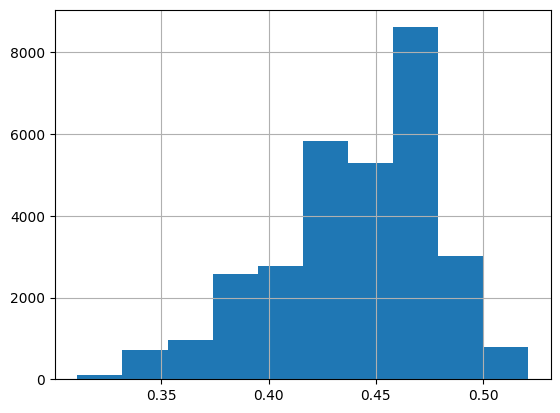

In [382]:
X_test["scores"].hist()